In [1]:
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
import numpy as np
import pandas as pd
import itertools
import os
import QCflow
from QCflow.load_gaussian import *
from QCflow.energy_calculations import *
from QCflow.torsion_parser import *

## An example walk through of data collection of one molecule:
#### 1. Isolated fragment data
#### 2. SYBA calculation
#### 3. Energy gap and planarity data
#### 4. Reorganisation energy calculation/data

### Example molecule

In [2]:
b_18_v2 = 'COc1cc2cc(-c3nccc4nsnc34)n(C)c2cc1OC'

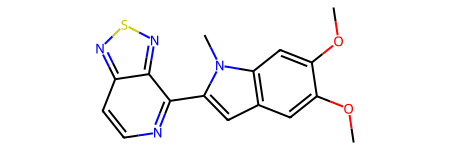

In [3]:
Chem.MolFromSmiles(b_18_v2)

## 1. Isolated fragment calculation

In [4]:
os.chdir('example_molecule_logs') # enter the directory where the log files are stored

In [5]:
mel_frag = {'b' : 'COC1=CC2=C(C=C1OC)N(C)C=C2'} #dictionary of eumelanin fragments
lit_frag = {'18' : 'C12=NSN=C1C=NC=C2'} #dictionary of pi-conjugated fragments from literature
combined_frag = mel_frag | lit_frag #combine the two dictionaries

In [6]:
mol_data = {}
mol_data_failed = {}
for k, v in combined_frag.items():
    data = load_data(k, 'opt') # use the log_data function to extract the data from the log files

    if data.metadata['success'] == True: # check if the calculation was successful
        mol_data[k] = data
    else:
        mol_data_failed[k] = v #if it failed at it to failed dictionary to keep track of which molecules failed

### Calculate the HOMO and the LUMO of the isolated fragments

In [7]:
homo_dic = {}
lumo_dic = {}
for k, v in mol_data.items():
    homo_dic[k] = cal_HOMO(v) #calculate the HOMO
    lumo_dic[k] = cal_LUMO(v) #calculate the LUMO

In [8]:
homo_dic

{'b': -4.825667024767, '18': -7.1198588983325}

In [9]:
lumo_dic

{'b': 0.3061280818125, '18': -2.8000515216450004}

#### Predict the energy gap if the fragments were combined

In [10]:
predicted_gap = {}
for k1, k2 in itertools.product(mel_frag.keys(), lit_frag.keys()):
    homo_k1 = homo_dic[f'{k1}']
    #k1 is the 'donor'                  
    lumo_k2 = lumo_dic[f'{k2}']
    #k2 is the 'acceptor'
    gap = np.abs(homo_k1 - lumo_k2) # predict the energy gap
    predicted_gap[f'{k1}_{k2}'] = gap

In [11]:
predicted_gap

{'b_18': 2.025615503122}

### The isolated fragments are combined and this is detailed in notebook XXXX

## 2. SYBA calculation

In [12]:
from syba.syba import SybaClassifier

In [13]:
syba = SybaClassifier()
syba.fitDefaultScore() #initialising SYBA

In [14]:
dyads = {'b_18_single_v2' : 'COc1cc2cc(-c3nccc4nsnc34)n(C)c2cc1OC'}

In [15]:
syba_dyads = {}
for k, v in dyads.items():
    syba_dyads[k] = syba.predict(v)

In [16]:
syba_dyads

{'b_18_single_v2': 50.47428760408039}

## 3. Energy gap and planarity data

#### Loading optimisation data

In [17]:
opt_data = {}
for k, v in dyads.items():
    opt = load_data(k, 'opt')
    opt_data[k] = opt

#### Testing if the calculations have been successful

In [18]:
passed_opt = {}
failed_opt = {}
for k, v in opt_data.items():
    if v.metadata['success'] == True:
        passed_opt[k] = v
    else:
        failed_opt[k] = dyads[k]

In [19]:
passed_opt

{'b_18_single_v2': <cclib.parser.data.ccData_optdone_bool at 0x16cf57d90>}

In [20]:
failed_opt

{}

#### Calculating the energy gap

In [21]:
eg_data = {}
for k, v in passed_opt.items():
    eg = np.abs(cal_gap(v))
    eg_data[k] = eg

In [22]:
eg_data

{'b_18_single_v2': 2.47079376254}

#### Calculating planarity

In [23]:
linker_planairty = {}
for k, v in passed_opt.items():
    if (k.split('_')[2] == 'thio') or (k.split('_')[2] == 'triple') or (k.split('_')[2] == 'double') or (k.split('_')[2] == 'imine'):
        linker_type = k.split('_')[2]
        linker_planairty[k] = finding_multi_planairty(k, dyads[k], linker_type) #finds planarity for systems with more than one dihedral

    if (k.split('_')[2] == 'single'):
        linker_type = k.split('_')[2]
        angle = finding_dihedral_opt(dyads[k], v)
        linker_planairty[k] = find_planarity(angle)

In [24]:
linker_planairty

{'b_18_single_v2': 0.9850536127974234}

## Reorganisation energy calculation and data

In [25]:
EcN = {}
EnC = {}
EcC = {}
EaA = {}
EnA = {}
EaN = {}
for k, v in dyads.items():
    ecc = load_data(k, 'opt_c') #cationic charge (geometry optimisation)
    ecn = load_data(k, 'sp_c') #cationic charge at neutral geometry (single point) relies on opt

    eaa = load_data(k, 'opt_a') #anionic charge (geometry optimisation)
    ean = load_data(k, 'sp_a') #anionic charge at neutral geometry (single point) relies on opt

    ena = load_data(k, 'n_a_geo') #neutral charge at cation geometry (single point) relies on opt_a calculation
    enc = load_data(k, 'n_c_geo') #neutral charge at anion geometry (single point) relies on opt_c calculation

    EcN[k] = ecn
    EnC[k] = enc
    EcC[k] = ecc
    EaA[k] = eaa
    EnA[k] = ena
    EaN[k] = ean

#### The success for the calculation was tested, just as it was previously for opt calculation

#### Anionic reorganisation calculation

In [26]:
cal_reorg_an = {}
for k, v in dyads.items():
    opt_n_data = passed_opt[k]

    an_reorg = cal_reorg(opt_n_data, EaN[k], EaA[k], EnA[k])
    cal_reorg_an[k] = an_reorg*1000 #convert to meV

In [27]:
cal_reorg_an

{'b_18_single_v2': 301.71766052080784}

#### Cationic reorganisation calculation

In [28]:
cal_reorg_cat = {}
for k, v in dyads.items():
    opt_n_data = opt_data[k]

    cat_reorg = cal_reorg(opt_n_data, EcN[k], EcC[k], EnC[k])
    cal_reorg_cat[k] = cat_reorg*1000 #convert to meV

In [29]:
cal_reorg_cat

{'b_18_single_v2': 294.75399497459875}

# End